In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

import os

In [115]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [116]:

TRAIN_PATH = "GTSRB/Final_Training/Images"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [117]:
TEST_PATH = "GTSRB/Final_Test/Images/"
CSV_PATH = "GTSRB/Final_Test/Images/GT-final_test.csv"
class CustomTestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        # read csv file, seperator is ';'
        self.dataframe = pd.read_csv(csv_file, sep=';')
        # look at columns of dataframe
        print(self.dataframe.columns)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, -1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Usage
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = CustomTestDataset(csv_file=CSV_PATH, 
                                 img_dir=TEST_PATH, 
                                 transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Index(['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2',
       'ClassId'],
      dtype='object')


In [118]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 43)  # GTSRB has 43 classes
model = model.to(device)

d:\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [119]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [120]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}")
            running_loss = 0.0

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\anaconda3\envs\pytorch\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\johnj\AppData\Local\Temp\ipykernel_13512\2360319284.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\anaconda3\envs\pytorch\Lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\pytorch\Lib\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\pytorch\Lib\site-packages\IPython\core\ultratb.py", line 1319, in structured_traceback
    return VerboseTB.structured_traceback(
       

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {(100 * correct / total):.2f}%')


Accuracy: 98.82%


In [ ]:
# save the weights
torch.save(model.state_dict(), 'initial_model_weights.pth')

In [ ]:
torch.save(model, 'initial_model.pth')

In [123]:
# load the model
model = torch.load('initial_model.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

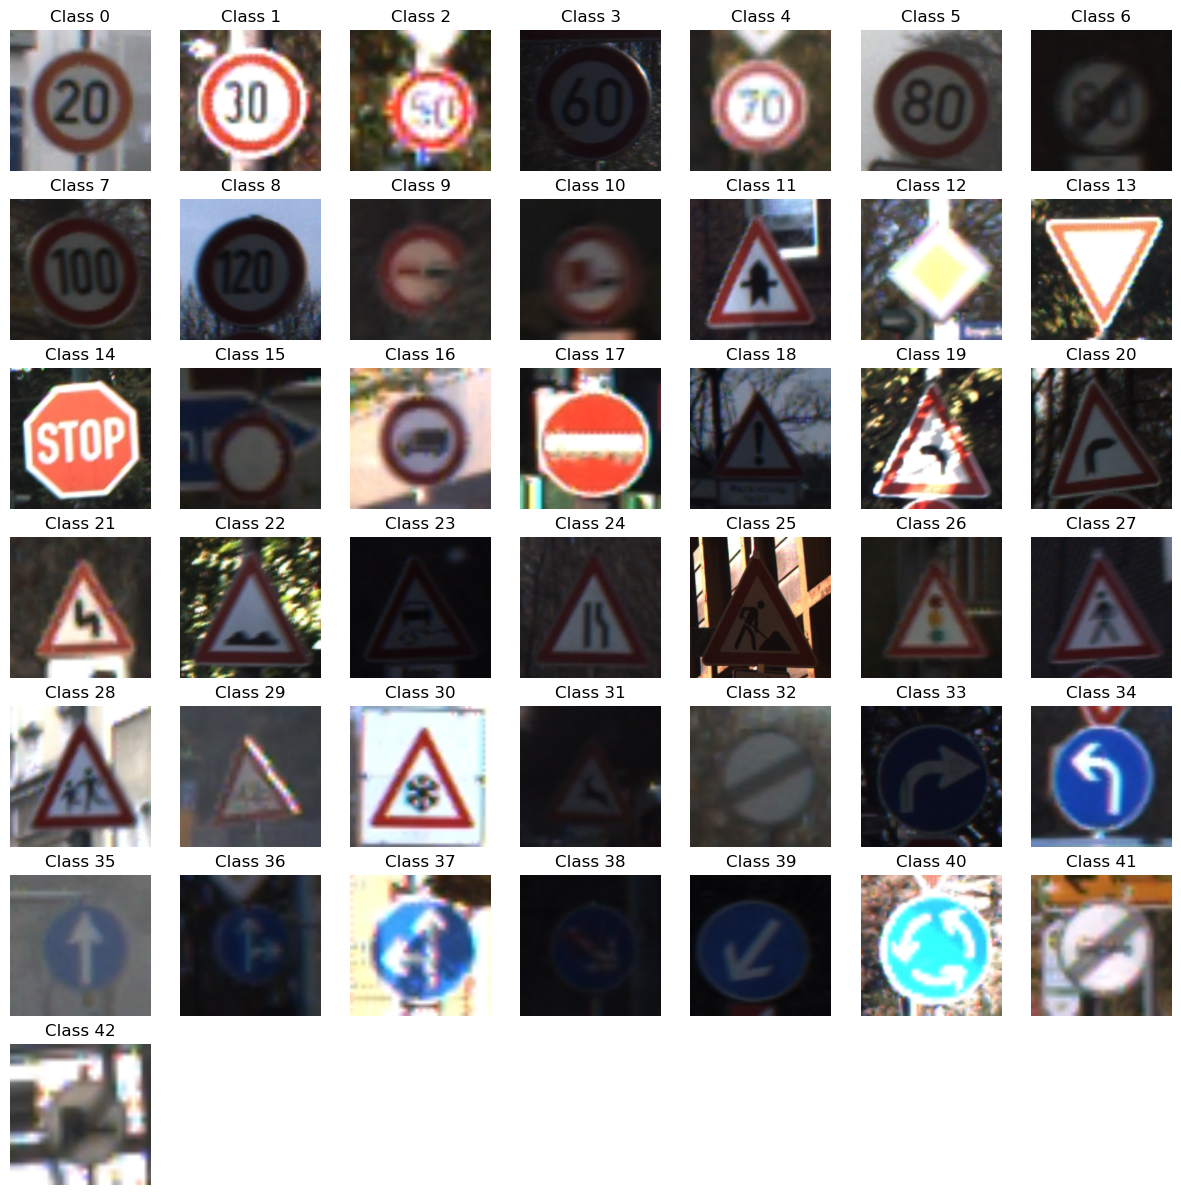

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a dictionary to hold one sample per class
class_samples = {}

# Function to unnormalize and convert tensor to numpy for plotting
def imshow(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # unnormalize
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)

    npimg = img_tensor.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Collect one sample per class from the training set
for images, labels in train_loader:
    for i in range(len(labels)):
        label = labels[i].item()
        if label not in class_samples:
            class_samples[label] = images[i]
    if len(class_samples) == 43:  # Assuming there are 43 classes in GTSRB
        break

# sort the dictionary by keys
class_samples = dict(sorted(class_samples.items()))

# Plot one image from each class
fig = plt.figure(figsize=(15, 15))
for i, (label, img) in enumerate(class_samples.items()):
    ax = fig.add_subplot(7, 7, i + 1)  # Assuming a grid size that can fit all classes
    ax.set_title(f"Class {label}")
    ax.axis("off")

    # process the image and show it
    imshow(img)
plt.show()

In [61]:
import torch.nn.functional as F

def fgsm_attack_with_preprocessing(image, model, epsilon):
    # Enable gradient calculation for the image
    image.requires_grad = True

    # Run the image through the model
    output = model(image)
  
    # Get the label (class) with the highest score
    _, label = output.max(1)

    # Calculate the loss
    loss = F.nll_loss(output, label)

    # Zero all existing gradients
    model.zero_grad()

    # Backward pass to get the gradients
    loss.backward()

    # Collect data gradient
    data_grad = image.grad.data

    # Generate perturbed image
    perturbed_image = image + epsilon * data_grad.sign()

    return perturbed_image


Ground truth class label: 21


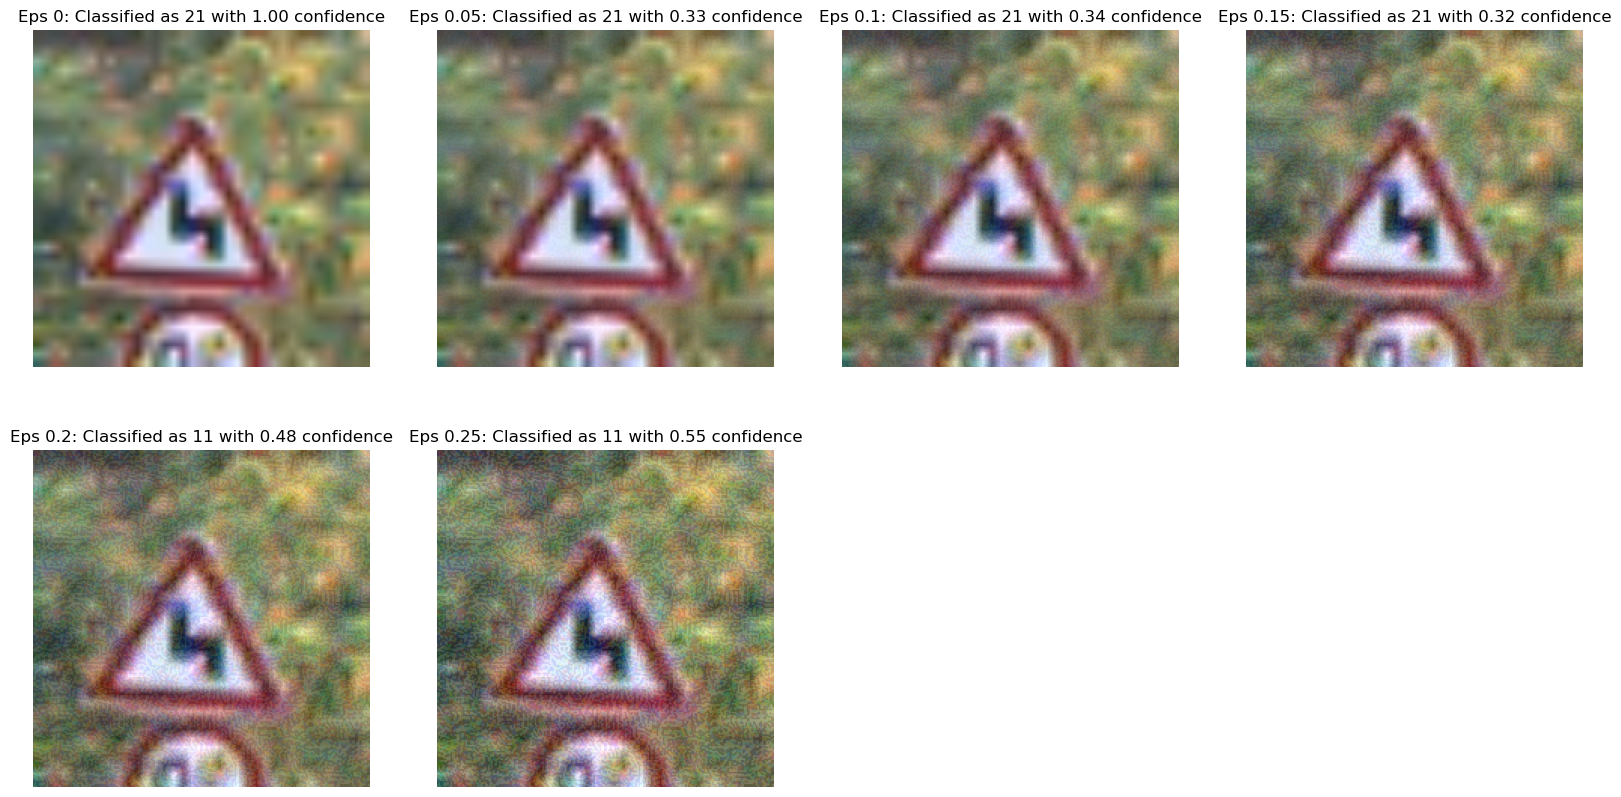

In [130]:
import random

model.eval()  # Set model to evaluation mode

# Load a random image from the test loader
test_iter = iter(test_loader)
images, labels = next(test_iter)
idx = random.randint(0, len(labels) - 1)
image, label = images[idx:idx+1], labels[idx:idx+1]
image, label = image.to(device), label.to(device)

# Print the ground truth label
print(f"Ground truth class label: {label.item()}")

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
ep_count = len(epsilons)

# Display original and perturbed images
PLOT_WIDTH = ep_count//2 + 1
PLOT_HEIGHT = 2

plt.figure(figsize=(PLOT_WIDTH*5, PLOT_HEIGHT*5))

# Run FGSM attack with different epsilon values
for i, eps in enumerate(epsilons):
    # Generate perturbed image
    perturbed_image = fgsm_attack_with_preprocessing(image, model, eps)
    # Classify the perturbed image
    perturbed_output = model(perturbed_image)
    _, perturbed_pred = perturbed_output.max(1)
    confidence = F.softmax(perturbed_output, dim=1)[0, perturbed_pred].item()


    # Convert tensors to NumPy arrays for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    perturbed_image = perturbed_image.detach()


    for t, m, s in zip( perturbed_image, mean, std):
        t.mul_(s).add_(m)

    perturbed_image = perturbed_image.squeeze().cpu().numpy()

    
    perturbed_image = perturbed_image.clip(0,1).transpose((1, 2, 0))

    plt.subplot(PLOT_HEIGHT, PLOT_WIDTH, i + 1)
    plt.title(f"Eps {eps}: Classified as {perturbed_pred.item()} with {confidence:.2f} confidence")
    plt.imshow(perturbed_image)
    plt.axis('off')

plt.show()


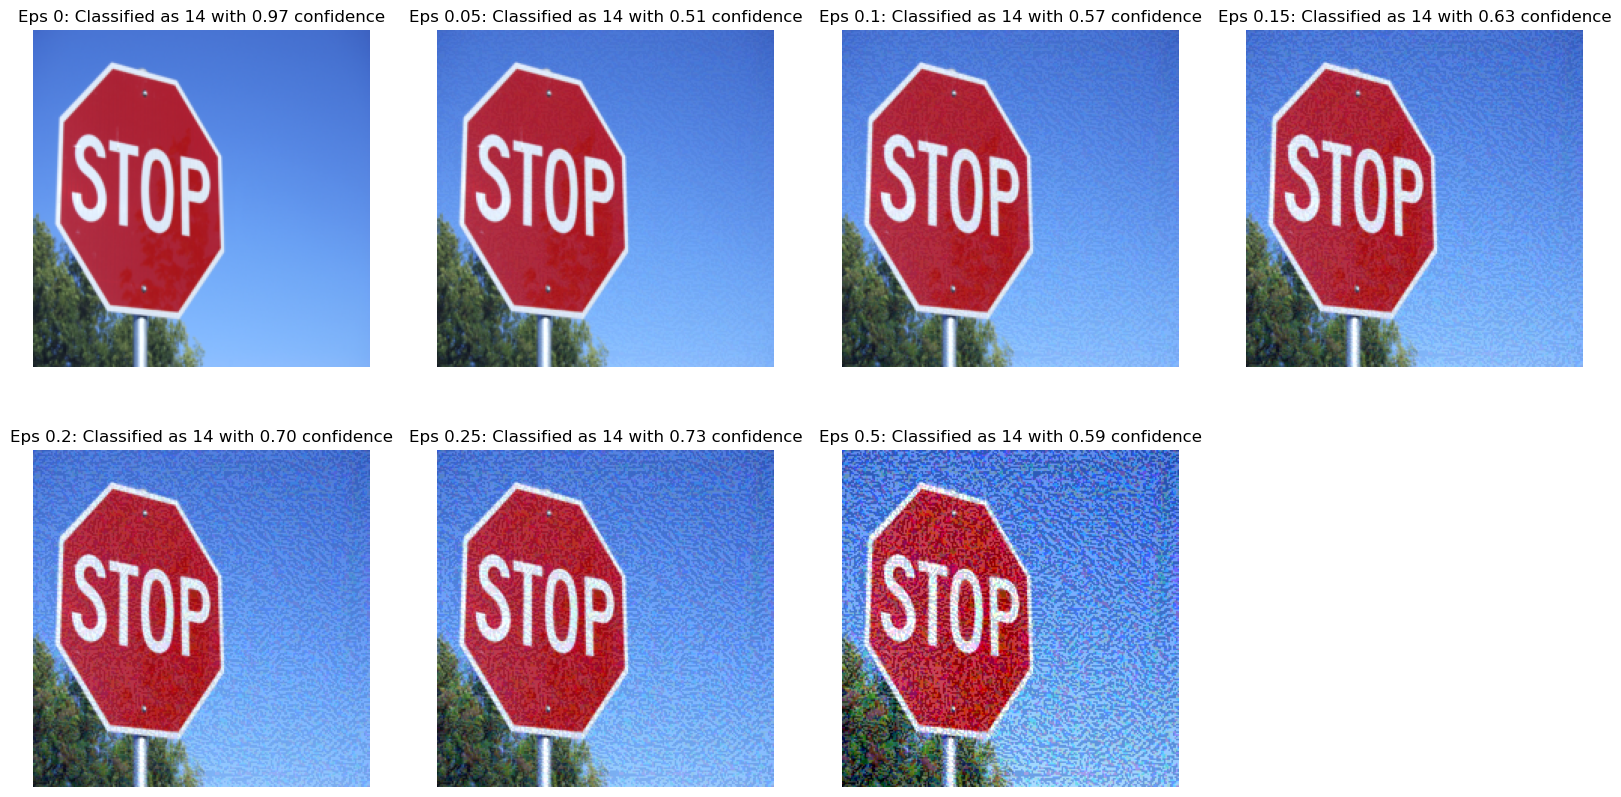

In [133]:
# Load and preprocess the image
image_path = "stop-sign1.jpg"  # Replace with the path to your image
input_image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model
image = input_batch.to(device)

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5]
ep_count = len(epsilons)

# Display original and perturbed images
PLOT_WIDTH = ep_count//2 + 1
PLOT_HEIGHT = 2

plt.figure(figsize=(PLOT_WIDTH*5, PLOT_HEIGHT*5))

# Run FGSM attack with different epsilon values
for i, eps in enumerate(epsilons):
    # Generate perturbed image
    perturbed_image = fgsm_attack_with_preprocessing(image, model, eps)
    # Classify the perturbed image
    perturbed_output = model(perturbed_image)
    _, perturbed_pred = perturbed_output.max(1)
    confidence = F.softmax(perturbed_output, dim=1)[0, perturbed_pred].item()


    # Convert tensors to NumPy arrays for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    perturbed_image = perturbed_image.detach()


    for t, m, s in zip( perturbed_image, mean, std):
        t.mul_(s).add_(m)

    perturbed_image = perturbed_image.squeeze().cpu().numpy()

    
    perturbed_image = perturbed_image.clip(0,1).transpose((1, 2, 0))

    plt.subplot(PLOT_HEIGHT, PLOT_WIDTH, i + 1)
    plt.title(f"Eps {eps}: Classified as {perturbed_pred.item()} with {confidence:.2f} confidence")
    plt.imshow(perturbed_image)
    plt.axis('off')

plt.show()
